In [2]:
%matplotlib inline

from os.path import join as pjoin
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from matplotlib import patheffects
pe = patheffects.withStroke(foreground="white", linewidth=3)
matplotlib.rcParams['font.sans-serif'] = 'Arial'


Load the classified storm data. This is *only* the visually classified events. The full event set are plotted elsewhere.

In [3]:
BASEDIR = r"..\data\training"
DATADIR = r"..\data\training"
eventFile = pjoin(BASEDIR, "visual_storm_types.csv")

stormdf = pd.read_csv(eventFile, usecols=[1, 2, 3],
                      parse_dates=['date'],
                      dtype={
                          'stnNum': int,
                          'stormType': 'category'
                          })

Plot a bar chart of the visually classified storm counts. The columns are re-ordered to match the grouping of non-convective, convective and error storm types.

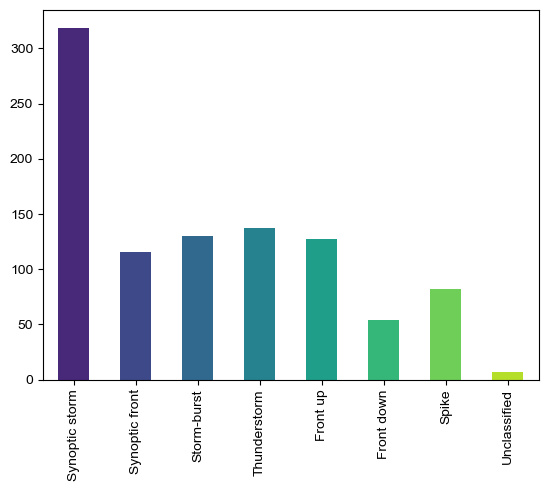

In [4]:
order = ["Synoptic storm", "Synoptic front", 
         "Storm-burst", "Thunderstorm",
         "Front up", "Front down",
         "Spike", "Unclassified"]
colors = sns.color_palette("viridis", n_colors=8)
stormdf.stormType.value_counts().loc[order].plot(kind='bar', color=colors)
plt.savefig(pjoin(BASEDIR, "plots", "visual_storm_counts.png"),
            bbox_inches="tight")

Load all the observed data, for all HQ stations and concatenate into a single dataframe. We then create a new attribute (called `idx`) that is a tuple of the MultiIndex of the dataframe (based on station and date)

In [5]:
stndf = pd.read_csv(pjoin("../data", 'hqstations.csv'), index_col="stnNum")

def loadData(stnNum):
    fname = pjoin(DATADIR, "events", f"{stnNum:06d}.pkl")
    df = pd.read_pickle(fname)
    df['date'] = pd.to_datetime(df['date'])
    df['stnNum'] = stnNum
    df.reset_index(inplace=True)
    # Create a MultiIndex based on station number and storm date:
    df.set_index(['stnNum', 'date'], inplace=True)
    return df

dflist = []
for stn in stndf.index:
    df = loadData(stn)
    dflist.append(df)

alldf = pd.concat(dflist)
alldf['idx'] = alldf.index

We create a similar attribute in the list of storm types, then create lists of indicies for each storm type.

In [6]:
stormdf['idx'] = stormdf[['stnNum', 'date']].apply(tuple, axis=1)

synidx = stormdf[stormdf['stormType']=="Synoptic storm"]['idx']
syfidx = stormdf[stormdf['stormType']=="Synoptic front"]['idx']
sbidx = stormdf[stormdf['stormType']=="Storm-burst"]['idx']

tsidx = stormdf[stormdf['stormType']=="Thunderstorm"]['idx']
fuidx = stormdf[stormdf['stormType']=="Front up"]['idx']
fdidx = stormdf[stormdf['stormType']=="Front down"]['idx']

ucidx = stormdf[stormdf['stormType']=="Unclassified"]['idx']
spidx = stormdf[stormdf['stormType']=="Spike"]['idx']

Then we can select the time series of each event that is classified as the selected storm type. We then group by the time difference (i.e. the time before/after the peak gust) and take the mean of all the values. 

In [7]:
synevents = alldf[alldf.idx.isin(synidx.values)]
syfevents = alldf[alldf.idx.isin(syfidx.values)]
sbevents = alldf[alldf.idx.isin(sbidx.values)]


tsevents = alldf[alldf.idx.isin(tsidx.values)]
fuevents = alldf[alldf.idx.isin(fuidx.values)]
fdevents = alldf[alldf.idx.isin(fdidx.values)]

ucevents = alldf[alldf.idx.isin(ucidx.values)]
spevents = alldf[alldf.idx.isin(spidx.values)]

meansyn = synevents.reset_index().groupby('tdiff').mean().reset_index()
meansyf = syfevents.reset_index().groupby('tdiff').mean().reset_index()
meansb = sbevents.reset_index().groupby('tdiff').mean().reset_index()

meants = tsevents.reset_index().groupby('tdiff').mean().reset_index()
meanfu = fuevents.reset_index().groupby('tdiff').mean().reset_index()
meanfd = fdevents.reset_index().groupby('tdiff').mean().reset_index()

meanuc = ucevents.reset_index().groupby('tdiff').mean().reset_index()
meansp = spevents.reset_index().groupby('tdiff').mean().reset_index()

C:\Users\u12161\AppData\Local\Temp\ipykernel_20292\3646302183.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  meansyn = synevents.reset_index().groupby('tdiff').mean().reset_index()
C:\Users\u12161\AppData\Local\Temp\ipykernel_20292\3646302183.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  meansyf = syfevents.reset_index().groupby('tdiff').mean().reset_index()
C:\Users\u12161\AppData\Local\Temp\ipykernel_20292\3646302183.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_on

The following code plots a multipanel figure with the mean time series of the eight storm types. There's some stuffing around to get multiple y-axes on each panel, and the labelling is done across multiple axes.

In [25]:
def plotEvent(df, ax):
    """
    Plot a time series onto an axis

    :param df: DataFrame containing time series of temperature, wind speed, dew point and station pressure values
    :param ax: `matplotlib.Axes`
    """
    axt = ax.twinx()
    axp = ax.twinx()
    ax.set_zorder(1)
    ax.patch.set_visible(False)
    l1 = axt.plot(df.tdiff, df.tempanom, label=r"Temperature [$^o$C]",
             color='r', marker='^', markerfacecolor="None", lw=1, path_effects=[pe], zorder=1,
             markevery=5)
    l2 = axt.plot(df.tdiff, df.dpanom, label=r"Dew point [$^o$C]", color='orangered', marker='.', markerfacecolor="None",
             lw=1, path_effects=[pe], zorder=1, markevery=5)
    
    l3 = ax.plot(df.tdiff, df.windgust, label="Wind gust [km/h]", color="#4C72B0",
            lw=2, path_effects=[pe], markerfacecolor="None",zorder=100)
    l4 = axp.plot(df.tdiff, df.stnpanom, label="Pressure [hPa]", color='purple', lw=2, path_effects=[pe],
             ls='--',)


    #axt.spines['right'].set_position(("axes", 1.075))
    axt.spines[['right']].set_color('r')
    axt.yaxis.label.set_color('r')
    axt.tick_params(axis='y', colors='r')
    #axt.set_ylabel(r"Temperature anomaly [$^o$C]")

    ax.set_ylabel("Gust wind speed [km/h]")

    axp.spines[['right']].set_position(('axes', 1.075))
    axp.spines[['right']].set_color('purple')
    axp.yaxis.label.set_color('purple')
    axp.tick_params(axis='y', colors='purple')
    #axp.set_ylabel("Pressure anomaly [hPa]")

    gmin, gmax = ax.get_ylim()
    pmin, pmax = axp.get_ylim()
    tmin, tmax = axt.get_ylim()
    ax.set_ylim((0, max(gmax, 100)))
    ax.set_xlim((-60, 60))
    axp.set_ylim((min(-2.0, pmin), max(pmax, 2.0)))
    axt.set_ylim((-4, 4))
    #axt.set_ylim((min(-2.0, tmin), max(tmax, 2.0)))
    #ax2.set_ylim((0, 360))
    #ax2.set_yticks(np.arange(0, 361, 90))
    #axr.set_ylim((0, 100))
    #ax.set_title(meants.index[0])
    ax.grid(True)
    #ax2.grid(False)
    axt.grid(False)
    axp.grid(False)
    #axr.grid(False)

def identify_axes(axdict, labels):
    kw = dict(ha="left", va="top", fontsize=12, color='black',
              bbox=dict(boxstyle='square',
                        ec="white",
                        fc="white",
                        alpha=0.7))
    for (k, ax), label in zip(axdict.items(), labels):
        ax.text(.02, 0.95, f"{k} {label}", transform=ax.transAxes, **kw)

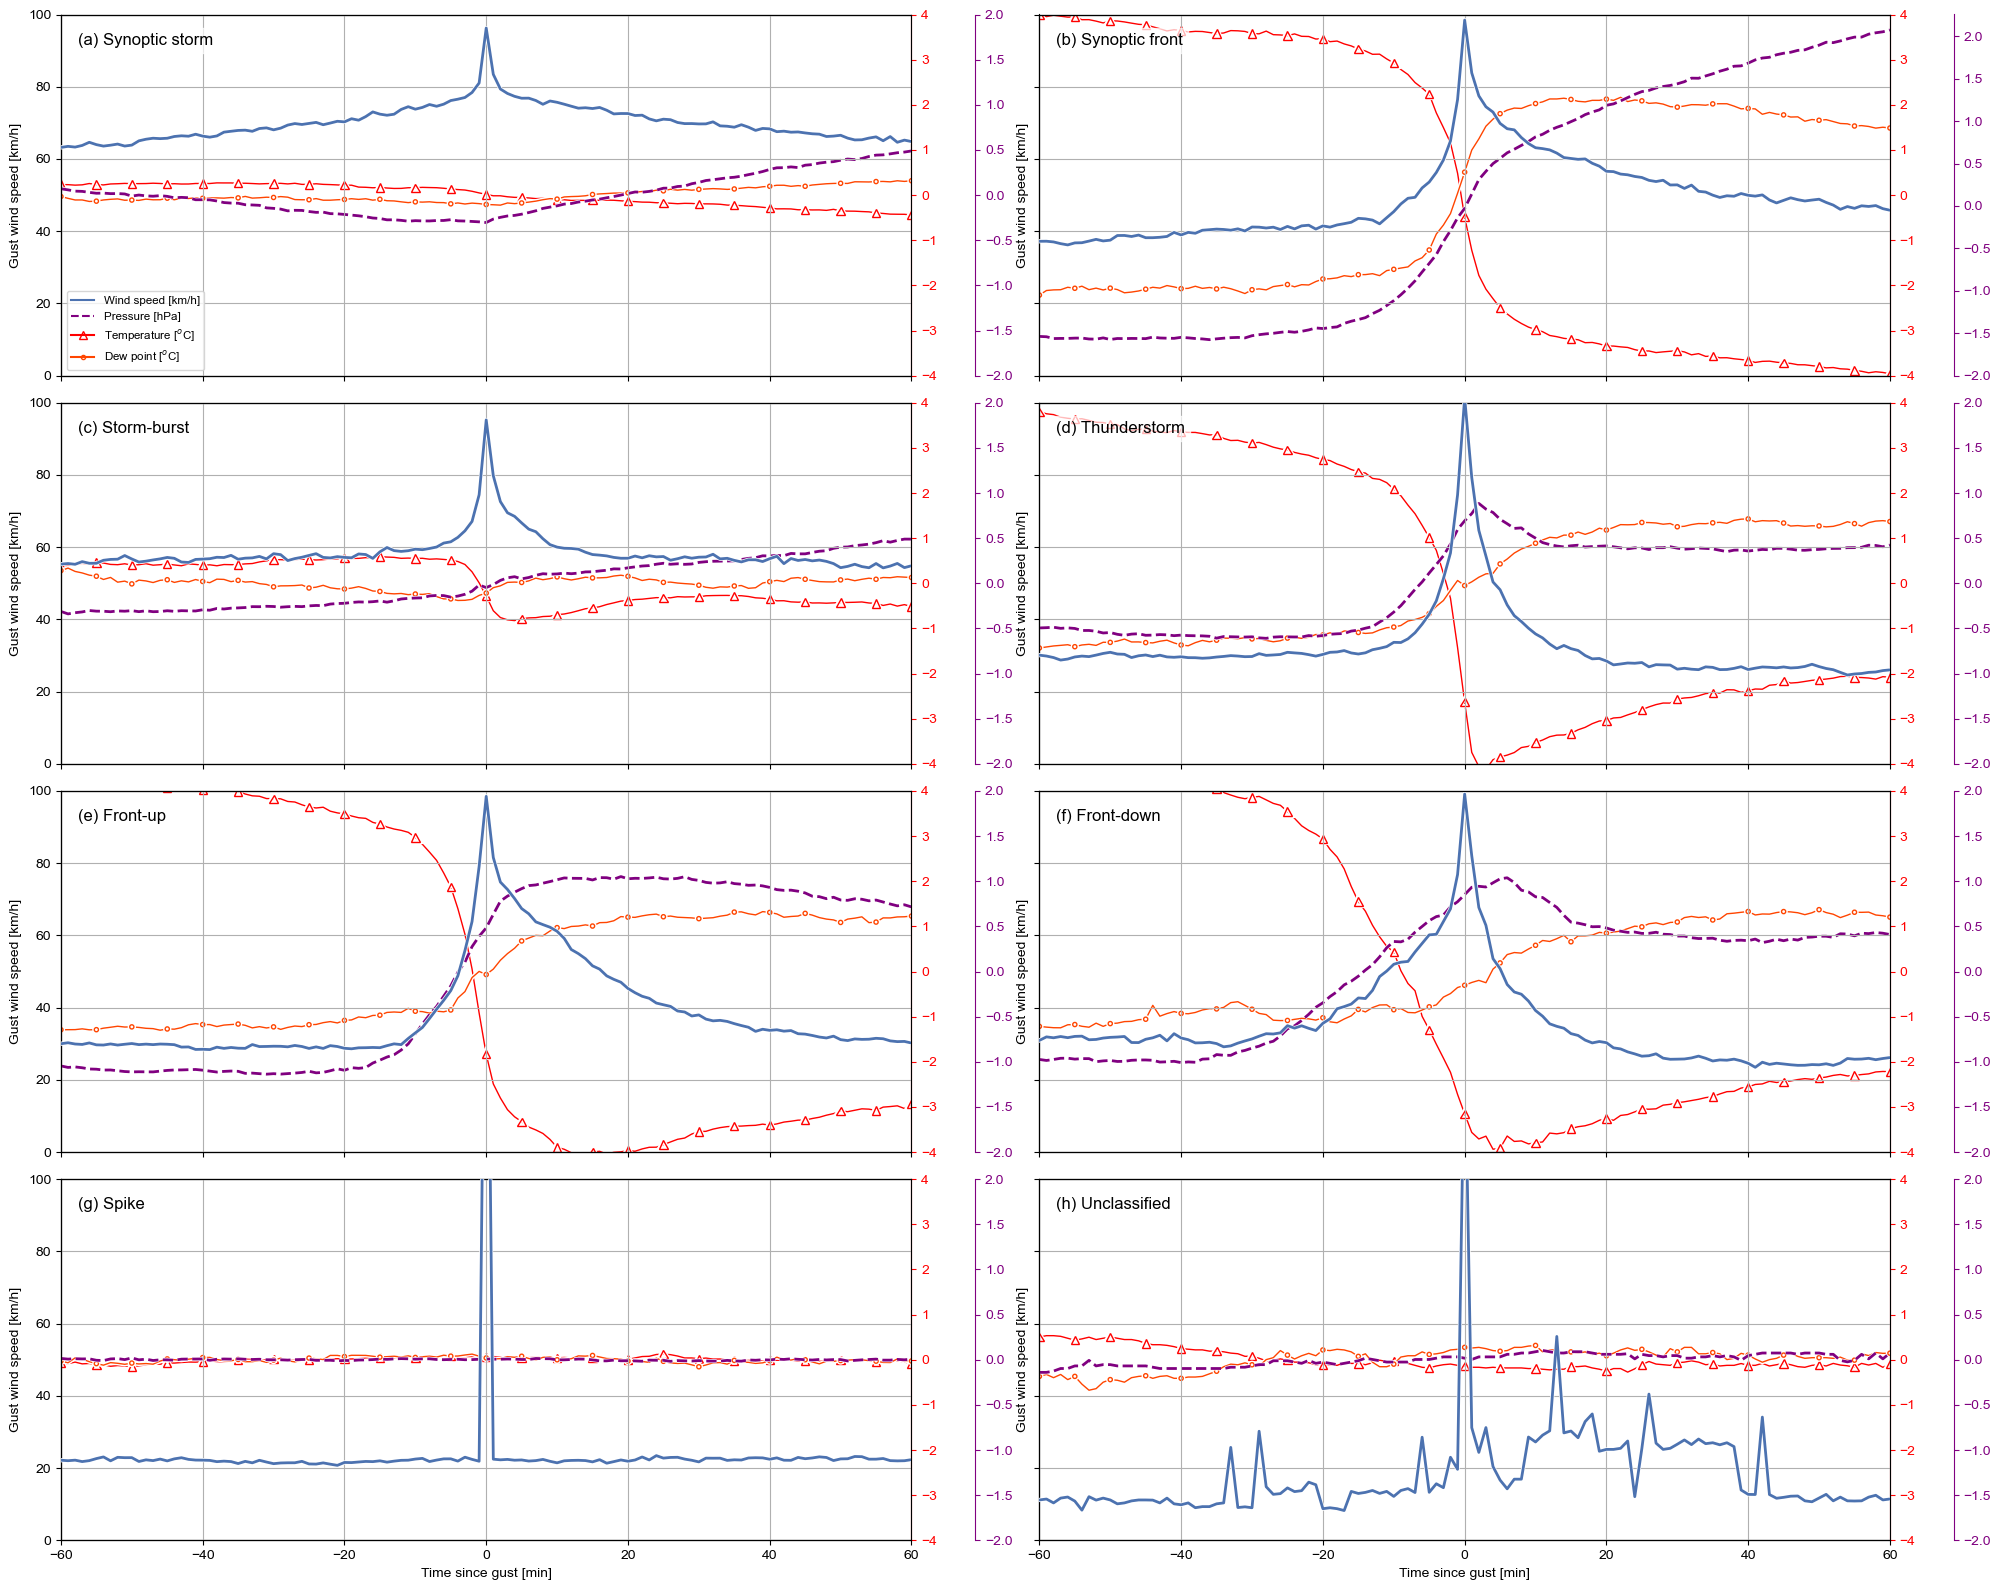

In [26]:
fig, axes = plt.subplot_mosaic(
    [["(a)", "(b)"],
     ["(c)", "(d)"],
     ["(e)", "(f)"],
     ["(g)", "(h)"]],
    sharex=True, sharey=True,
    figsize=(20, 16)
)

plotEvent(meansyn, axes['(a)'])
plotEvent(meansyf, axes['(b)'])
plotEvent(meansb, axes['(c)'])
plotEvent(meants, axes['(d)'])
plotEvent(meanfu, axes['(e)'])
plotEvent(meanfd, axes['(f)'])
plotEvent(meansp, axes['(g)'])
plotEvent(meanuc, axes['(h)'])
identify_axes(axes, labels=
              ["Synoptic storm", "Synoptic front", 
               "Storm-burst", "Thunderstorm",
               "Front-up", "Front-down",
               "Spike", "Unclassified"])
tlegendline = mlines.Line2D([], [], color='red', marker='^',
                            markerfacecolor="None",
                            label=r"Temperature [$^o$C]")
dlegendline = mlines.Line2D([], [], color='orangered',
                            marker='.', markerfacecolor="None",
                            label=r"Dew point [$^o$C]")
plegendline = mlines.Line2D([], [], color='purple',
                            ls='--', label=r"Pressure [hPa]")
wlegendline = mlines.Line2D([], [], color='#4C72B0',
                            label=r"Wind speed [km/h]")
axes['(a)'].legend(handles=[wlegendline, plegendline,
                            tlegendline, dlegendline], loc=3,
                   fontsize='small')
axes['(g)'].set_xlabel("Time since gust [min]")
axes['(h)'].set_xlabel("Time since gust [min]")
plt.tight_layout()

fig.savefig(pjoin(BASEDIR, "plots", "mean_visual_storm_profile.png"),
            bbox_inches="tight")

In [10]:
def loadGustRatioData(stnNum):
    fname = pjoin(BASEDIR, "gustratio", f"{stnNum:06d}.pkl")
    df = pd.read_pickle(fname)
    df['date'] = pd.to_datetime(df['date'])
    df['stnNum'] = stnNum
    df.reset_index(inplace=True)
    df.set_index(['stnNum', 'date'], inplace=True)
    return df

In [11]:
grdflist = []
for stn in stndf.index:
    df = loadGustRatioData(stn)
    grdflist.append(df)

allgrdf = pd.concat(grdflist)
allgrdf['idx'] = allgrdf.index

Here we join the manually classified set of events with the automatically classified events (based on the gust ratio). We reset the index of the dataframe holding the manually classified data to match the index of the automatically classified events and provide a suffix to separate the overlapping column names. A cross-tabulation then gives the comparison of events with different classifications. 

In [12]:
compdf = pd.merge(stormdf.set_index(['stnNum', 'date']), allgrdf, suffixes=('_s', '_g'))

In [24]:
colorder = ['Synoptic storm', 'Synoptic front', 'Storm-burst',
            'Thunderstorm', 'Front up', 'Front down',
            'Spike', 'Unclassified']
pd.crosstab(compdf['stormType'], compdf['category']).reindex(colorder).style.background_gradient(cmap='viridis_r')

category,convective,synoptic
stormType,,
Synoptic storm,31,288
Synoptic front,94,22
Storm-burst,36,94
Thunderstorm,135,2
Front up,120,7
Front down,53,1
Spike,82,0
Unclassified,7,0
